In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
#DEPENDENCIES/LIBRARIES

import tensorflow as tf
import numpy as np 
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for preprocessing
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 
import re


#Loading some sklearn packages for modelling
from sklearn.model_selection import train_test_split

#Keras libraries
from keras.preprocessing.text import Tokenizer
from keras.layers import BatchNormalization


import warnings
warnings.filterwarnings('ignore')
print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.6.2


In [2]:
# Input data files are available in the read-only "../input/" directory
data=pd.read_csv('../input/suicide-watch/Suicide_Detection.csv')
data.head()


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


# RENAMING COLUMNS 

In [3]:
data.columns = ['unknown', 'text', 'sentiment']
data.head()

,unknown,text,sentiment
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
df = data.drop(['unknown'], axis=1)
df

,text,sentiment
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
232069,If you don't like rock then your not going to ...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,The usual stuff you find hereI'm not posting t...,suicide


In [5]:
df['sentiment'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

# VISUALIZING DATA TO GAIN INSIGHTS

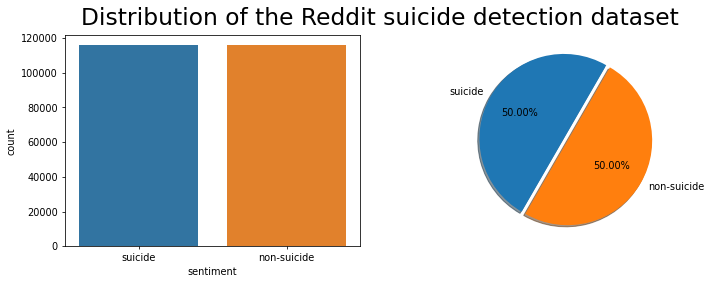

In [6]:
#displaying distribution of target column 
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(df['sentiment'], ax=axes[0])
axes[1].pie(df['sentiment'].value_counts(),
            labels=['suicide','non-suicide'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Reddit suicide detection dataset', fontsize=24)
plt.show()

As a quick and easy observation, we can say that our  dataset is not skewed and  has no imbalanced label problem. depression and non-depression labels are equal. The situation of equilibrium will let our model learn more accurately. 

# TEXT PREPROCESSING
We perform some pre-processing techniques such as lower casing the words and stopword removal. We also do lemmatization and tokenization later

In [7]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
text_cleaning_re = "[^A-Za-z0-9]"

In [8]:
def preprocess(text, lemma=False):
  text = re.sub(text_cleaning_re,' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if lemma:
        tokens.append(lemmatizer.lemma(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [9]:
df.text = df.text.apply(lambda x: preprocess(x))
df.head(10)

,text,sentiment
0,ex wife threatening suiciderecently left wife ...,suicide
1,weird get affected compliments coming someone ...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im crying hard,suicide
4,losthello name adam 16 struggling years afraid...,suicide
5,honetly idki dont know im even feel like nothi...,suicide
6,trigger warning excuse self inflicted burns kn...,suicide
7,ends tonight anymore quit,suicide
8,everyone wants edgy making self conscious feel...,non-suicide
9,life 20 years oldhello 20 year old balding mal...,suicide


In [10]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df.text)

In [11]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

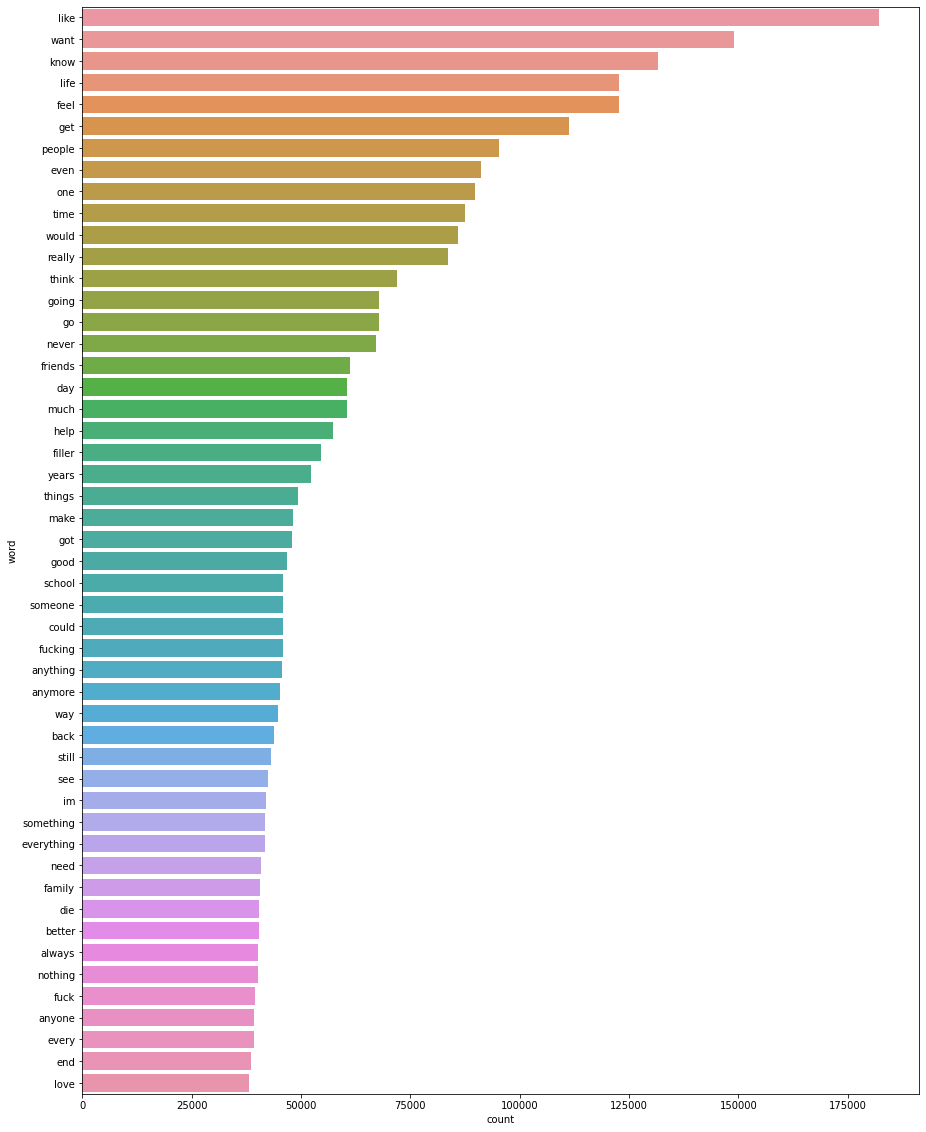

In [12]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

# Word cloud representation of SUICIDE dataset related words

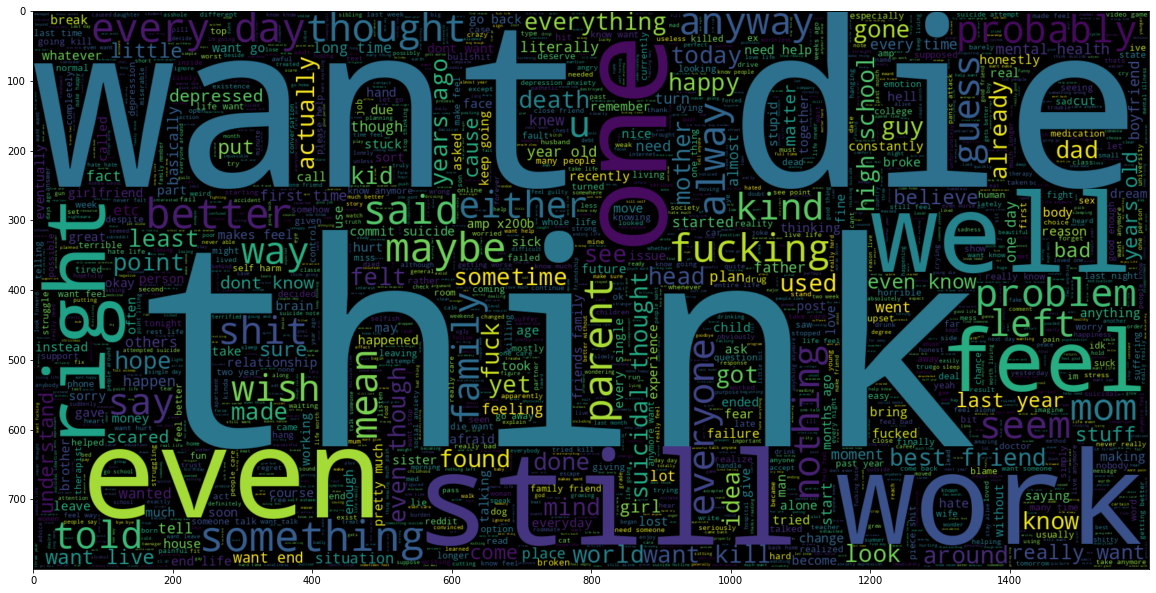

In [13]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'suicide'].text))
plt.imshow(wc , interpolation = 'bilinear')

# Word Cloud representatipon of NON-SUICIDE dataset related words

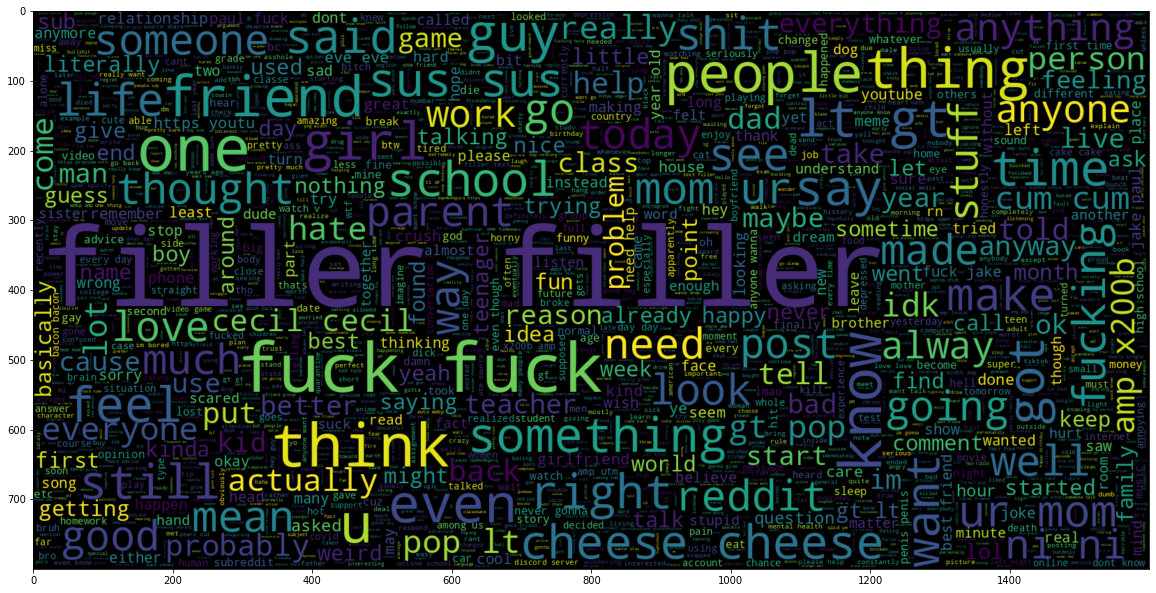

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'non-suicide'].text))
plt.imshow(wc , interpolation = 'bilinear')

# DATA SET SPLIT
We are splitting the data into train and test subsets with a standard 80% and 20% split ratio. the meothod train_test_split will shuffle(random_state) the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training to reduce the chances of memorization.

In [15]:
TRAIN_SIZE = 0.8
#MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, 
                                         random_state=10) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))
test_data.head(10)
test_data.isnull().sum()

Train Data size: 185659
Test Data size 46415


text         0
sentiment    0
dtype: int64

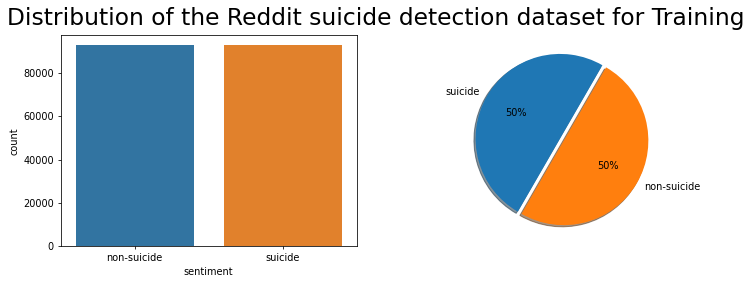

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(train_data['sentiment'], ax=axes[0])
axes[1].pie(train_data['sentiment'].value_counts(),
            labels=['suicide','non-suicide'],
            autopct='%1.0f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Reddit suicide detection dataset for Training', fontsize=24)
plt.show()

In [18]:
train_data.head(10)

,text,sentiment
57153,hey east cost ya guys doin whats snow like,non-suicide
143188,ate edible ate edible looking fun stuff sittin...,non-suicide
109923,helplessness last week two realised really lik...,suicide
115420,want win election labeled discussion fight ins...,non-suicide
44691,toothpicks one thing lie doctors family basica...,suicide
136381,crisis changing meds around getting pristiq ye...,suicide
21632,gonna alone foreveri failure gonna 25 months o...,suicide
215543,ideal romantic date give money,non-suicide
187798,acutaully happened awhile ago new kid class th...,non-suicide
171094,want never depressed whole life family longer ...,suicide


# TOKENIZATION

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 142991


# PADDING

In [20]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)


Training X Shape: (185659, 30)
Testing X Shape: (46415, 30)


# LABEL ENCODING

In [21]:
labels = train_data.sentiment.unique().tolist()
labels

['non-suicide', 'suicide']

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (185659, 1)
y_test shape: (46415, 1)


# WORD EMBEDDING
Instead of training features from our dataset, we download a pre-trained word embedding and use it as basis for our model.We use transfer learning to sync the embedding layer to the rest of our model. The embedding layer acts as a foundation. So we use a popular word embedding called **Glove Embedding** developed by Stanford University [(https://nlp.stanford.edu/projects/glove/)]

In [23]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [24]:
GLOVE_EMB = '../input/glove-embeddings/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 20
#MODEL_PATH = '.../output/kaggle/working/best_model.h5'

In [25]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [26]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# BUILDING DEEP LEARNING MODEL (EMBEDDING LAYER+CNN+BiLTSM+FC Layers)
CNN+RNN(able to loop important informations from layers. able to use prior features to predict next suitable words in a sentence)

In [28]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D,MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.25)(embedding_sequences)
x = Conv1D(filters=300, kernel_size=5,padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = SpatialDropout1D(0.25)(x)
x = Bidirectional(LSTM(64,dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

2022-01-25 13:48:11.448023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 13:48:11.590817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 13:48:11.591976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 13:48:11.593520: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           42897300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 300)           450300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 300)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 300)           1200      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 300)           0     

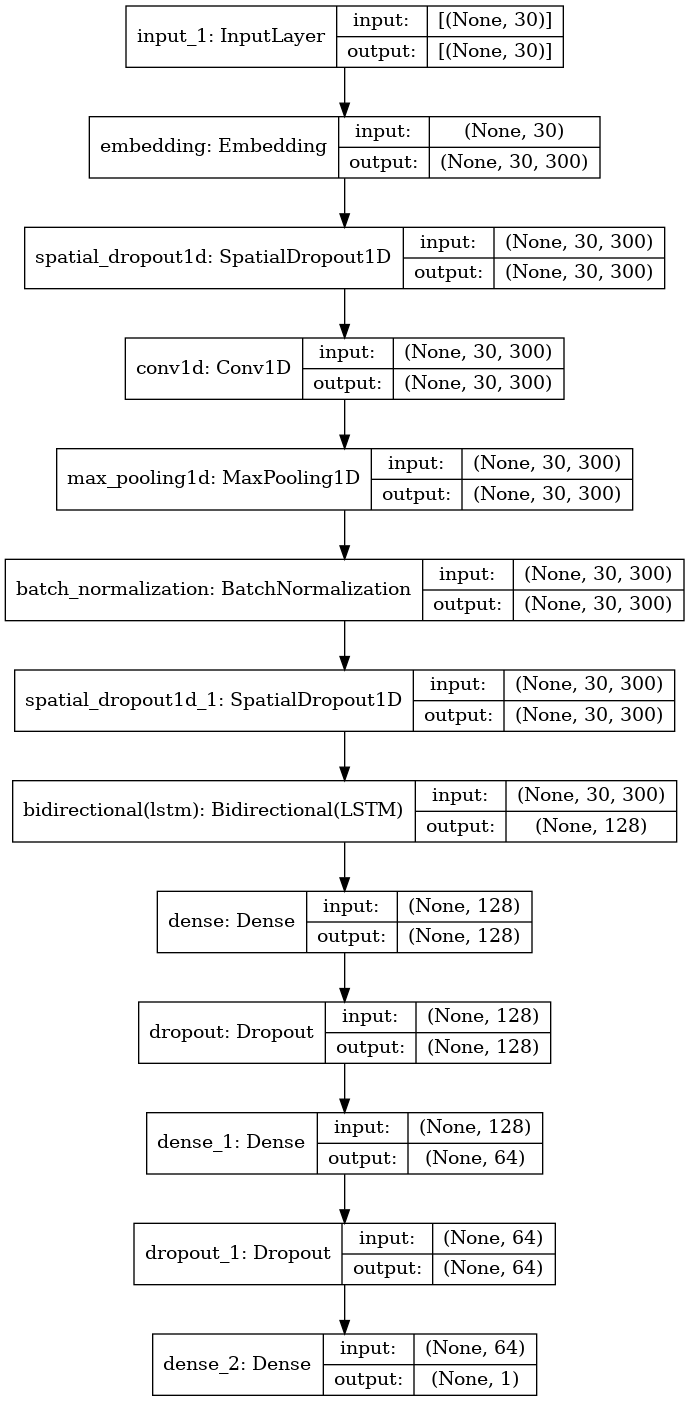

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent using a stochastic Gradient Descent(localization).

# Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch.

**LR(Learning Rate Scheduler)**- It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch if the learning plateaus.



In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [33]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


2022-01-25 13:48:16.034838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 13:48:16.035738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 13:48:16.036514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 13:48:16.037408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 13:48:16.037995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [34]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

2022-01-25 13:48:16.128152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-01-25 13:48:23.436331: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1451/1451 [==============================] - 659s 445ms/step - loss: 0.3187 - accuracy: 0.8722 - val_loss: 0.2643 - val_accuracy: 0.9042
Epoch 2/20
1451/1451 [==============================] - 648s 447ms/step - loss: 0.2629 - accuracy: 0.8988 - val_loss: 0.2385 - val_accuracy: 0.9053
Epoch 3/20
1451/1451 [==============================] - 639s 440ms/step - loss: 0.2444 - accuracy: 0.9060 - val_loss: 0.2349 - val_accuracy: 0.9114
Epoch 4/20
1451/1451 [==============================] - 644s 444ms/step - loss: 0.2321 - accuracy: 0.9116 - val_loss: 0.2323 - val_accuracy: 0.9130
Epoch 5/20
1451/1451 [==============================] - 644s 444ms/step - loss: 0.2227 - accuracy: 0.9146 - val_loss: 0.2663 - val_accuracy: 0.9088
Epoch 6/20
1451/1451 [==============================] - 646s 445ms/step - loss: 0.2161 - accuracy: 0.9172 - val_loss: 0.2234 - val_accuracy: 0.9174
Epoch 7/20
1451/1451 [==============================] - 645s 444ms/step - loss: 0.2089 - accuracy: 0.9199 - val_loss: 0.224

In [35]:
model.save("extremedepression_detectionmodel.h5") 

# EVALUATION USING THE ACCURACY AND LOSS CURVE FOR LEARNING

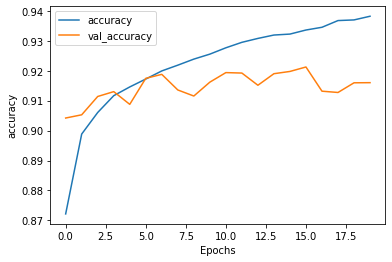

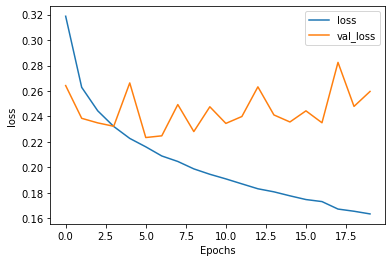

In [36]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# PREDICTIONS
 We define a threshold value.intuitively we place our threshold value in the middle.at 0.5. Scores below the threshold value is predicted as non-suicidal sentences whiles scores above the threshold are predicted as suicidal

In [37]:
def decode_sentiment(score):
    return "suicide" if score>0.5 else "non-suicide"


scores = model.predict(x_test, verbose=1, batch_size=128)
prediction = [decode_sentiment(score) for score in scores]

363/363 [==============================] - 10s 26ms/step


# ANALYSIS OF PREDICTION DONE ON TEST DATASET

In [38]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,normalize=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)



    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

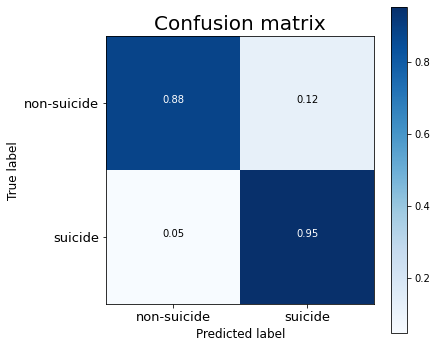

In [39]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), prediction)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [40]:
print(classification_report(test_data.sentiment.to_list(), prediction))

              precision    recall  f1-score   support

 non-suicide       0.95      0.88      0.91     23209
     suicide       0.89      0.95      0.92     23206

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415

